In [45]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

## Gather the DATA
We are simply fetching the data from drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [53]:
def load_data(path, data_type="train"):
  file_path = os.path.join(path, (data_type + ".xlsx"))
  if data_type == "test":
    return pd.read_excel(file_path, index_col='id')
  else:
    return pd.read_excel(file_path)

In [17]:
data_path = "/content/drive/MyDrive/device_price_classification_data/"
data = load_data(data_path)
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1.0,0.0,7.0,0.6,188.0,2.0,...,20.0,756.0,2549.0,9.0,7.0,19,0,0,1,1
1,1021,1,0.5,1,0.0,1.0,53.0,0.7,136.0,3.0,...,905.0,1988.0,2631.0,17.0,3.0,7,1,1,0,2
2,563,1,0.5,1,2.0,1.0,41.0,0.9,145.0,5.0,...,1263.0,1716.0,2603.0,11.0,2.0,9,1,1,0,2
3,615,1,2.5,0,0.0,0.0,10.0,0.8,131.0,6.0,...,1216.0,1786.0,2769.0,16.0,8.0,11,1,0,0,2
4,1821,1,1.2,0,13.0,1.0,44.0,0.6,141.0,2.0,...,1208.0,1212.0,1411.0,8.0,2.0,15,1,1,0,1


## Exploring Data

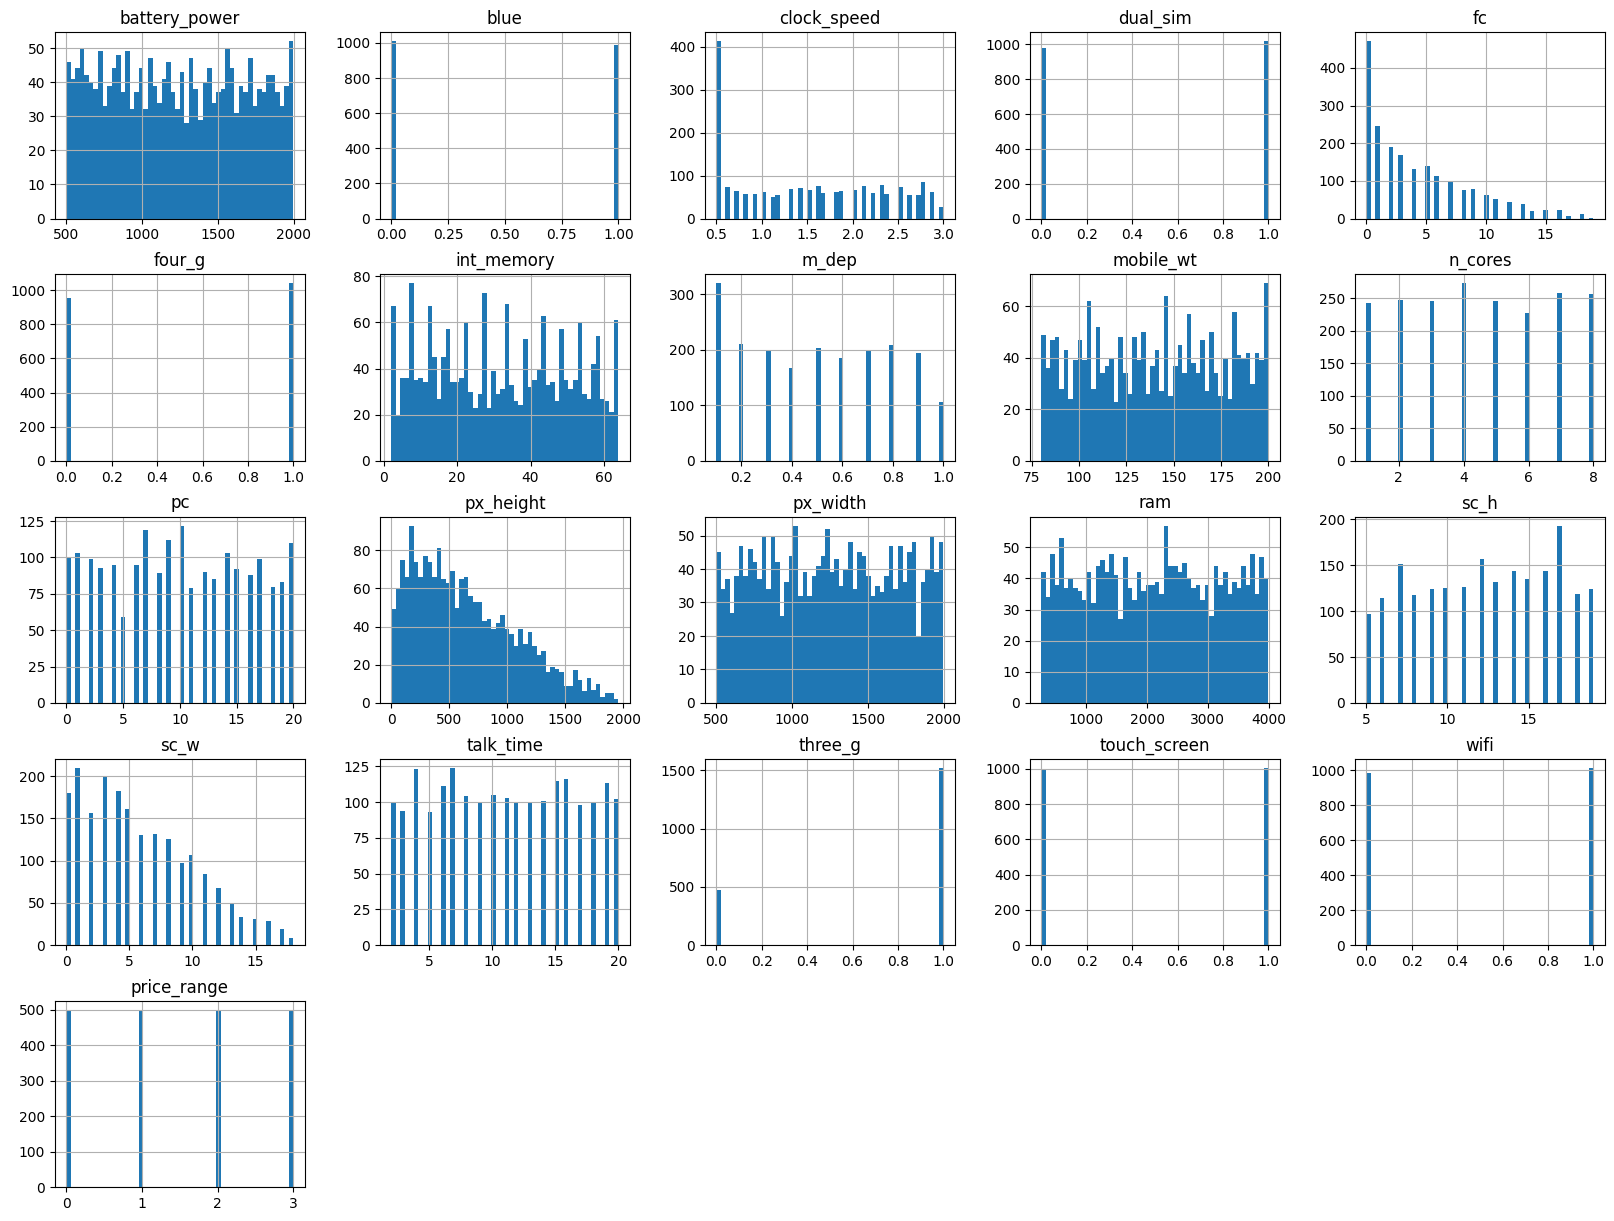

In [18]:
data.hist(bins=50, figsize=(20,15))
plt.show()

As you can see, the data is well distributed and there is no apparent bias.

In [19]:
data["price_range"].value_counts()

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64

In [26]:
print("Number of attributes: ", len(list(data.columns)))

Number of attributes:  21


Looking for correlation between features.

array([[<Axes: xlabel='battery_power', ylabel='battery_power'>,
        <Axes: xlabel='clock_speed', ylabel='battery_power'>,
        <Axes: xlabel='ram', ylabel='battery_power'>,
        <Axes: xlabel='four_g', ylabel='battery_power'>,
        <Axes: xlabel='price_range', ylabel='battery_power'>],
       [<Axes: xlabel='battery_power', ylabel='clock_speed'>,
        <Axes: xlabel='clock_speed', ylabel='clock_speed'>,
        <Axes: xlabel='ram', ylabel='clock_speed'>,
        <Axes: xlabel='four_g', ylabel='clock_speed'>,
        <Axes: xlabel='price_range', ylabel='clock_speed'>],
       [<Axes: xlabel='battery_power', ylabel='ram'>,
        <Axes: xlabel='clock_speed', ylabel='ram'>,
        <Axes: xlabel='ram', ylabel='ram'>,
        <Axes: xlabel='four_g', ylabel='ram'>,
        <Axes: xlabel='price_range', ylabel='ram'>],
       [<Axes: xlabel='battery_power', ylabel='four_g'>,
        <Axes: xlabel='clock_speed', ylabel='four_g'>,
        <Axes: xlabel='ram', ylabel='four_g'>,
 

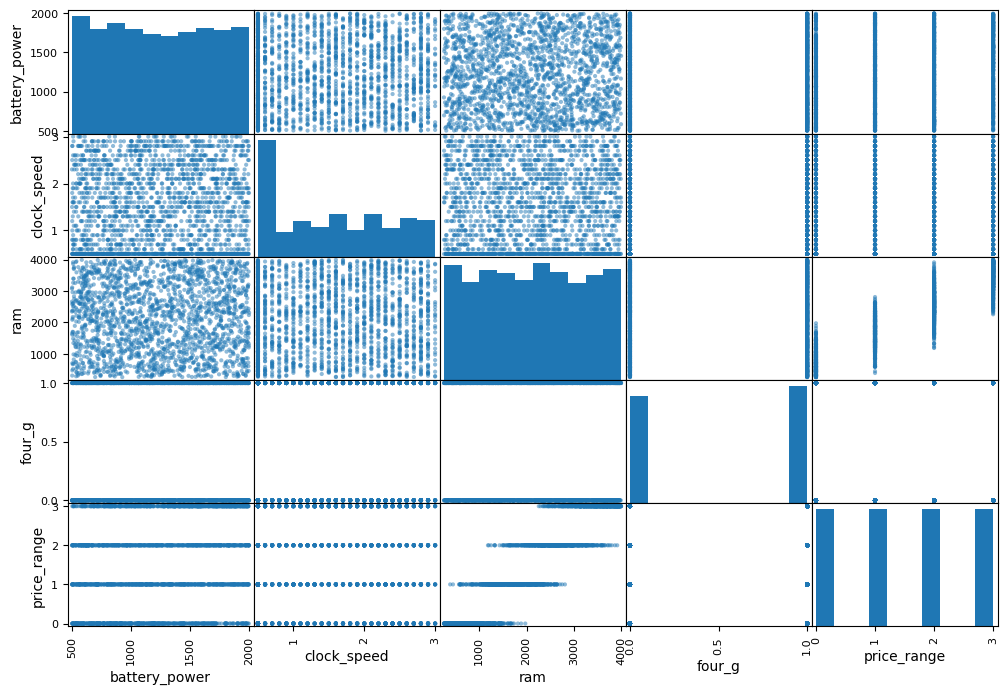

In [22]:
attributes = ["battery_power", "clock_speed", "ram", "four_g", "price_range"]
scatter_matrix(data[attributes], figsize=(12, 8))

It seems like there is no correlation appearing between the selected features except for RAM.
a device can have 4g and still be at low cost.
a device can have vety low battery power and still be expensive. and so on.

In [27]:
labels = data["price_range"].copy()
data = data.drop("price_range", axis=1)

In [28]:
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,842,0,2.2,0,1.0,0.0,7.0,0.6,188.0,2.0,2.0,20.0,756.0,2549.0,9.0,7.0,19,0,0,1
1,1021,1,0.5,1,0.0,1.0,53.0,0.7,136.0,3.0,6.0,905.0,1988.0,2631.0,17.0,3.0,7,1,1,0
2,563,1,0.5,1,2.0,1.0,41.0,0.9,145.0,5.0,6.0,1263.0,1716.0,2603.0,11.0,2.0,9,1,1,0
3,615,1,2.5,0,0.0,0.0,10.0,0.8,131.0,6.0,9.0,1216.0,1786.0,2769.0,16.0,8.0,11,1,0,0
4,1821,1,1.2,0,13.0,1.0,44.0,0.6,141.0,2.0,14.0,1208.0,1212.0,1411.0,8.0,2.0,15,1,1,0


## Data Cleaning

In [29]:
assert len(data) == len(labels)

Check for features with missing values.

In [33]:
print ("Features with Nan values:")
for attrib in list(data.columns):
  if (data[attrib].isnull().values.any()):
    print(attrib)

Features with Nan values:
fc
four_g
int_memory
m_dep
mobile_wt
n_cores
pc
px_height
px_width
ram
sc_h
sc_w


In [14]:
print(data["n_cores"].unique())

[ 2.  3.  5.  6.  1.  8.  4.  7. nan]


In [13]:
missing_categorical_columns = ["four_g", "n_cores"]

In [34]:
def fill_missing_values(df, categorical_columns=None):

    if categorical_columns is None:
        categorical_columns = []

    for column in df.columns:
        if column in categorical_columns:
            # If column is specified as categorical
            df[column].fillna(-1, inplace=True)

        else:
            median_value = df[column].median()
            df[column].fillna(median_value, inplace=True)

    return df

Here, we handle categorical features differently from numerical features.

In [35]:
cleaned_data = fill_missing_values(data, missing_categorical_columns)

In [36]:
cleaned_data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,842,0,2.2,0,1.0,0.0,7.0,0.6,188.0,2.0,2.0,20.0,756.0,2549.0,9.0,7.0,19,0,0,1
1,1021,1,0.5,1,0.0,1.0,53.0,0.7,136.0,3.0,6.0,905.0,1988.0,2631.0,17.0,3.0,7,1,1,0
2,563,1,0.5,1,2.0,1.0,41.0,0.9,145.0,5.0,6.0,1263.0,1716.0,2603.0,11.0,2.0,9,1,1,0
3,615,1,2.5,0,0.0,0.0,10.0,0.8,131.0,6.0,9.0,1216.0,1786.0,2769.0,16.0,8.0,11,1,0,0
4,1821,1,1.2,0,13.0,1.0,44.0,0.6,141.0,2.0,14.0,1208.0,1212.0,1411.0,8.0,2.0,15,1,1,0


In [37]:
for attrib in list(cleaned_data.columns):
  print(cleaned_data[attrib].isnull().values.any())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


## Data Preprocessing

In [83]:
full_pipeline = StandardScaler()

data_prepared = full_pipeline.fit_transform(cleaned_data)

Feature engineering involve scaling numerical features because they are on different scales.

## Data Split
 Here, we make a validation set to see how the model is generalizing.

In [84]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_prepared, labels, test_size=0.2, random_state=42)

## Training Algorithm and Evaluation

For classification tasks like this, algorithms like Random Forest, Gradient Boosting Machines (GBM), Support Vector Machines (SVM), or even simple classifiers like Logistic Regression can be effective. These algorithms handle categorical data well and can capture complex relationships between features and target variables.

In [85]:
# Initialize and train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate Random Forest Classifier
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Classification Report:")
print(classification_report(y_test, rf_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))

# Initialize and train Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions on the test set
gb_predictions = gb_model.predict(X_test)

# Evaluate Gradient Boosting Classifier
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("\nGradient Boosting Classifier Accuracy:", gb_accuracy)
print("Classification Report:")
print(classification_report(y_test, gb_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, gb_predictions))

# Initialize and train Logistic Regression Classifier
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions on the test set
lr_predictions = lr_model.predict(X_test)

# Evaluate Logistic Regression Classifier
lr_accuracy = accuracy_score(y_test, lr_predictions)
print("\nLogistic Regression Classifier Accuracy:", lr_accuracy)
print("Classification Report:")
print(classification_report(y_test, lr_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, lr_predictions))


Random Forest Classifier Accuracy: 0.8875
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       105
           1       0.88      0.85      0.86        91
           2       0.78      0.87      0.82        92
           3       0.95      0.87      0.91       112

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400

Confusion Matrix:
[[101   4   0   0]
 [  6  77   8   0]
 [  0   7  80   5]
 [  0   0  15  97]]

Gradient Boosting Classifier Accuracy: 0.9125
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       105
           1       0.89      0.91      0.90        91
           2       0.84      0.86      0.85        92
           3       0.94      0.91      0.92       112

    accuracy                           0.91       400
   macro 

it seems like simple Logistic regression made a decent job compared to other algorithms.

In [86]:
conf_mx = confusion_matrix(y_test, lr_predictions)

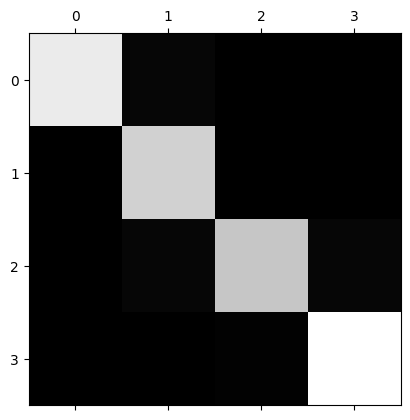

In [87]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

## Serialize Model using Pickle

In [88]:
import pickle

# Serialize and save the lr_model using pickle
with open('lr_model.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

## Making Prediction on the TEST set

In [89]:
test_df = load_data(data_path, "test")

In [90]:
test_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
id,,,,,,,,,,,,,,,,,,,,
1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1


In [91]:
print("Number of attributes: ", len(list(test_df.columns)))

Number of attributes:  20


In [92]:
cleaned_test_data = fill_missing_values(test_df, missing_categorical_columns)


In [93]:
test_full_pipeline = StandardScaler()

In [94]:
X_test_ = test_full_pipeline.fit_transform(cleaned_test_data)

In [95]:
print(X_test_.shape)

(1000, 20)


In [96]:
print(list(cleaned_data.columns) == list(cleaned_test_data.columns))

True


In [97]:
lr_predictions_test = lr_model.predict(X_test_)

In [101]:
test_df['price_range'] = list(lr_predictions_test)

In [102]:
test_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
id,,,,,,,,,,,,,,,,,,,,,
1,1043,1,1.8,1,14,0,5,0.1,193,3,...,226,1412,3476,12,7,2,0,1,0,3
2,841,1,0.5,1,4,1,61,0.8,191,5,...,746,857,3895,6,0,7,1,0,0,3
3,1807,1,2.8,0,1,0,27,0.9,186,3,...,1270,1366,2396,17,10,10,0,1,1,2
4,1546,0,0.5,1,18,1,25,0.5,96,8,...,295,1752,3893,10,0,7,1,1,0,3
5,1434,0,1.4,0,11,1,49,0.5,108,6,...,749,810,1773,15,8,7,1,0,1,1
